In [18]:
import itertools
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
import pandas as pd
import seaborn as sns

import gensim.downloader as api
from nltk.corpus import stopwords
from strictly_typed_pandas import DataSet
from typing import List, Dict

from gensim.models import KeyedVectors
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_predict, train_test_split
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/troyjennings/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [19]:
stopwords = stopwords.words('english')

# Data Loading

Import the featurized dataset and drop the unnecessary columns. Import word-vectors from the pretrained GLOVE model.

In [20]:
reviews_labeled = pd.read_csv('../data/interim/reviews_featurized.csv')
reviews_labeled.drop(labels=['clean_tokenized_review', 'lemma', 'sentiment'], axis=1, inplace=True)
reviews_labeled.sample(5)

,review_text,n_tokens,lemma_sent,polarity,subjectivity,negative,neutral,positive,compound,target
13220,"This is not my usual style, but the print is g...",48,usual style print gorgeous dress really high q...,0.151607,0.588571,0.045,0.578,0.377,0.9653,0
16896,I am a size 2 and the skirt fit however it is ...,13,size skirt fit however thick voluminous look l...,0.033333,0.291667,0.138,0.575,0.287,0.3818,1
5448,"Comfortable, stretchy fabric. i ordered the xs...",17,comfortable stretchy fabric order xs probably ...,0.166667,0.533333,0.000,0.721,0.279,0.7003,0
14782,I have many ponchos! i think they are timeless...,30,many ponchos think timeless fun sophisticate o...,0.416667,0.516667,0.000,0.545,0.455,0.9638,0
3667,I bought this as a swimsuit cover and it was e...,14,buy swimsuit cover exactly like picture soft g...,0.350000,0.340000,0.000,0.324,0.676,0.9403,0


In [21]:
# Import and load the pretrained Word2Vec model and the Google news 300 dataset.
if not os.path.exists('../data/wordvectors/word2vec-google-news-300.wordvectors'):
    wv = api.load('word2vec-google-news-300')
    print('done loading word2vec, saving')
    wv.save('../data/wordvectors/word2vec-google-news-300.wordvectors')
    print('wordvectors available at ../data/wordvectors/word2vec-google-news-300.wordvectors')
else:
    print('wordvectors already available, not re-downloading')

# load the word2vec model
path_to_wordvectors = '../data/wordvectors/word2vec-google-news-300.wordvectors'
glove_w2v_model = KeyedVectors.load(path_to_wordvectors)
print(f'done loading Word2Vec as {type(glove_w2v_model)}')

wordvectors already available, not re-downloading
done loading Word2Vec as <class 'gensim.models.keyedvectors.KeyedVectors'>


# Helper Functions

In [22]:
def embedding_feats(document): 
    '''
    Calcualtes a word-2-vector matrix for an individual document.

    Parameters
    ----------
    document : str      
        The lemma from a review test.

    Returns
    -------
    feat
        The featurized vector for the document.
    '''
    DIMENSION = 300
    zero_vector = np.zeros(DIMENSION)

    feat_for_this =  np.zeros(DIMENSION) # create a zero-vector of length DIMENSION
    count_for_this = 0 + 1e-5 # to avoid divide-by-zero 

    for token in document.split(' '):
        if token in glove_w2v_model:
            feat_for_this += glove_w2v_model[token]
            count_for_this += 1
    if count_for_this != 0:
        feat = feat_for_this / count_for_this
    else:
        feat = zero_vector
    return feat

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 fontsize=12,
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)

# Data Preprocessing

In [23]:
# preprocessing pipeline
column_trans = ColumnTransformer([
    ('scaler', MinMaxScaler(), ['n_tokens', 'polarity', 'compound']),
], verbose_feature_names_out=True)

column_trans.fit(reviews_labeled)
trans = column_trans.transform(reviews_labeled)
transformed = pd.DataFrame(trans, columns=['t_n_tokens', 't_polarity', 't_compound'])

reviews_labeled = pd.concat([reviews_labeled, transformed], axis=1)
reviews_labeled.drop(labels=['n_tokens', 'polarity', 'compound'], axis=1, inplace=True)

reviews_feats = reviews_labeled['lemma_sent'].apply(lambda r: embedding_feats(r)) 
reviews_labeled.insert(len(reviews_labeled.columns), 'w2v_feat', reviews_feats)
reviews_labeled.sample(5)

,review_text,lemma_sent,subjectivity,negative,neutral,positive,target,t_n_tokens,t_polarity,t_compound,w2v_feat
16448,Love the shape of this top and often look to r...,love shape top often look retailer corsetstyle...,0.545000,0.064,0.496,0.439,1,0.821429,0.600635,0.987490,"[0.03478589351267336, 0.06746605774769804, -0...."
6053,I agree that the color in the picture online i...,agree color picture online lighter buy store r...,0.570000,0.000,0.406,0.594,0,0.303571,0.730000,0.980977,"[0.036619377984894175, 0.06380204788775118, -0..."
19589,I don't think it's possible to say enough good...,think possible say enough good things dress fi...,0.610985,0.000,0.490,0.510,0,0.696429,0.725000,0.994159,"[0.019394678989220877, 0.024859612925721766, -..."
1215,Picture definitely does not do this vest justi...,picture definitely vest justice saw rack try i...,0.336111,0.000,0.570,0.430,0,0.714286,0.533160,0.987852,"[0.02889641778059932, 0.035470349104030706, -0..."
14166,I bought this in the faded pink rose color (wh...,buy fade pink rise color inexplicably call red...,0.606250,0.000,0.721,0.279,0,0.696429,0.512500,0.969449,"[0.021044916613770843, 0.027958672209550697, -..."


# Modeling

## Data Partitioning

In [24]:
X = reviews_labeled.drop(labels='target', axis=1)
y = reviews_labeled['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(15848, 10) (6793, 10) (15848,) (6793,)


In [25]:
# save the preprocessed data for the distributional tests, hyperparameter tuning, and error analysis to avoid data leakage
pd.concat([X_train, y_train], axis=1).to_csv('../data/final/train.csv', index=False)
pd.concat([X_test, y_test], axis=1).to_csv('../data/final/test.csv', index=False)

In [26]:
# drop unnesseary features for the bow-based and embedding-based models, respectively
X_train_emb = X_train.drop(labels=['review_text', 'lemma_sent'], axis=1)
X_train_bow = X_train.drop(labels=['review_text', 'w2v_feat'], axis=1)

In [27]:
# define the preprocessor pipelines
MAX_FEAT = 5000 # maximum features from the word vector representation
NUMERICALS = ['subjectivity', 'negative', 'neutral', 'positive', 't_n_tokens', 't_polarity', 't_compound']
TARGETS = ['recommended', 'not-recommended']

numeric_preproc = ColumnTransformer([('scaler', MinMaxScaler(), NUMERICALS)])
bow_preproc = ColumnTransformer([('vectorizer', CountVectorizer(max_features=MAX_FEAT), 'lemma_sent')])
n_grams_preproc = ColumnTransformer([('vectorizer', CountVectorizer(max_features=MAX_FEAT, ngram_range=(1, 3)), 'lemma_sent')])
tfidf_preproc = ColumnTransformer([('vectorizer', TfidfVectorizer(max_features=MAX_FEAT), 'lemma_sent')])

# define models
log_reg_base = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
rand_frst_base = RandomForestClassifier(random_state=42)
svm_base = LinearSVC(class_weight='balanced', max_iter=MAX_FEAT)
models = {
    'Logistic Regression': log_reg_base, 
    'Random Forest': rand_frst_base, 
    'Support Vector Machine': svm_base
}

## Bag-of-Word Models

Classification Report : Logistic Regression

-------------------------------------
                 precision    recall  f1-score   support

    recommended       0.94      0.88      0.91     12994
not-recommended       0.59      0.76      0.66      2854

       accuracy                           0.86     15848
      macro avg       0.77      0.82      0.79     15848
   weighted avg       0.88      0.86      0.87     15848

Confusion Matrix : Logistic Regression

-------------------------------------


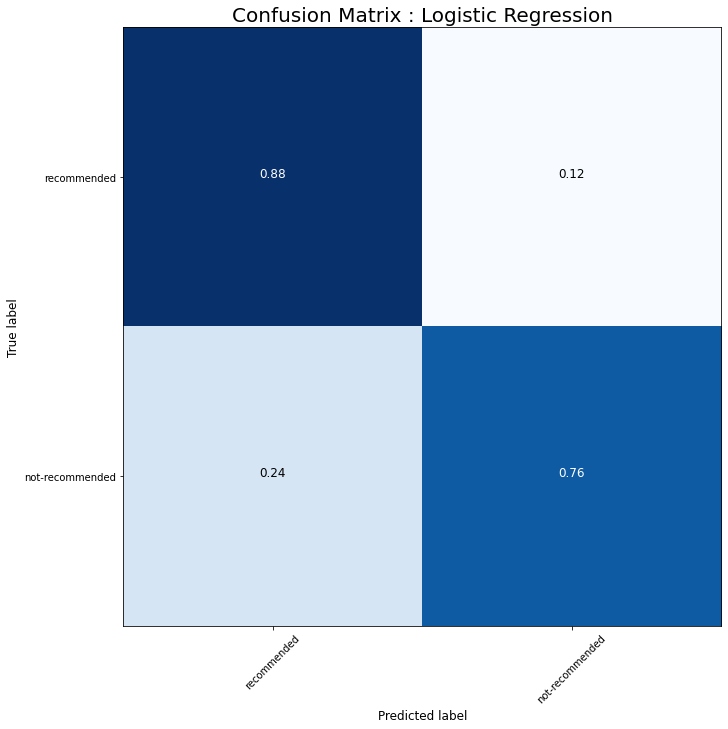

Classification Report : Random Forest

-------------------------------------
                 precision    recall  f1-score   support

    recommended       0.86      0.99      0.92     12994
not-recommended       0.83      0.24      0.38      2854

       accuracy                           0.85     15848
      macro avg       0.84      0.62      0.65     15848
   weighted avg       0.85      0.85      0.82     15848

Confusion Matrix : Random Forest

-------------------------------------


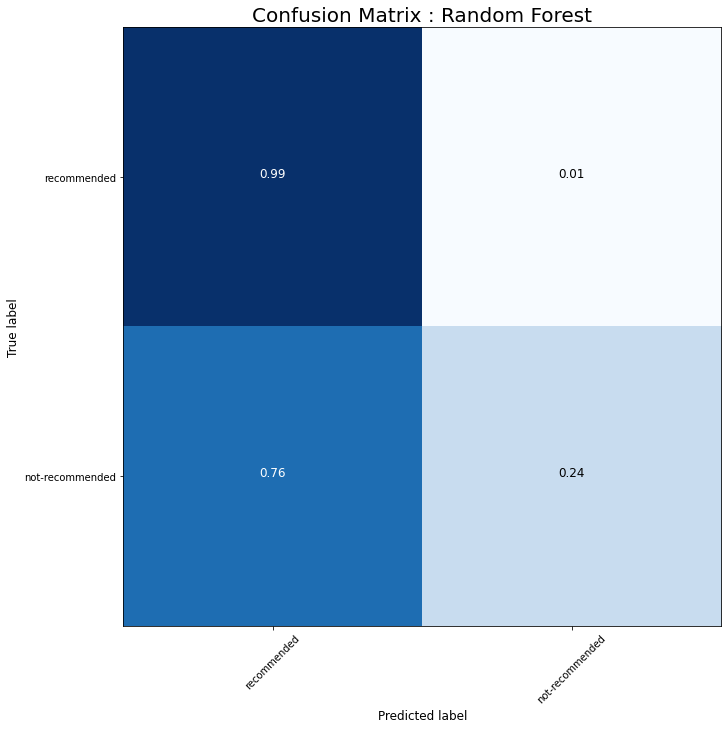

Classification Report : Support Vector Machine

-------------------------------------
                 precision    recall  f1-score   support

    recommended       0.93      0.89      0.91     12994
not-recommended       0.57      0.68      0.62      2854

       accuracy                           0.85     15848
      macro avg       0.75      0.78      0.76     15848
   weighted avg       0.86      0.85      0.86     15848

Confusion Matrix : Support Vector Machine

-------------------------------------


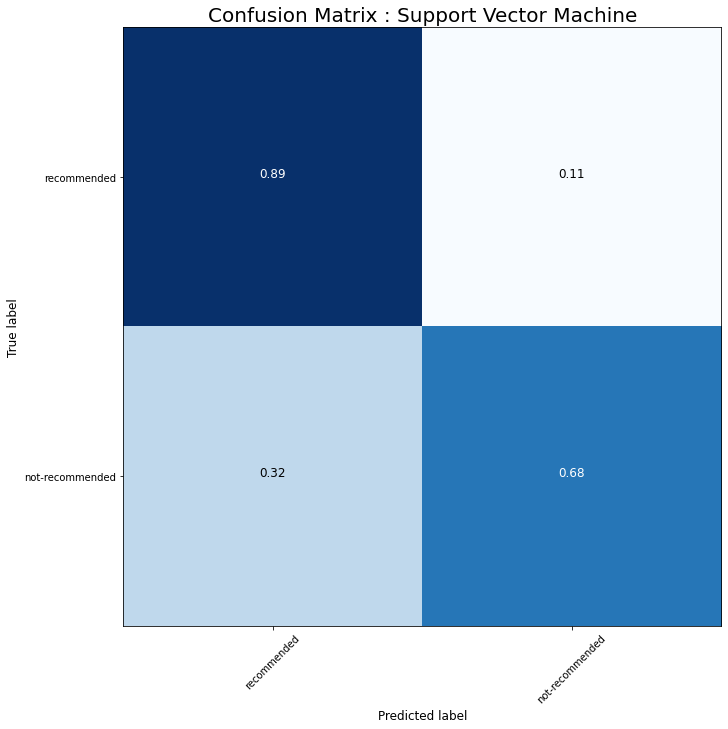

In [28]:
# combine the features
feature_combiner = FeatureUnion([('numeric', numeric_preproc), ('text', bow_preproc)])

for model in models.items():
    
    # create the pipeline
    pipe = Pipeline([
        ('preproc', feature_combiner),
        ('clf', model[1])
    ])

    # print classification reports
    y_pred = cross_val_predict(pipe, X_train_bow, y_train)
    print(f'Classification Report : {model[0]}\n')
    print('-------------------------------------')
    print(classification_report(y_train, y_pred, target_names=TARGETS))

    # print confusion matrices
    print(f'Confusion Matrix : {model[0]}\n')
    print('-------------------------------------')
    plot_confusion_matrix(confusion_matrix(y_train, y_pred), classes=['recommended','not-recommended'], normalize=True, title=f'Confusion Matrix : {model[0]}')
    plt.grid(False)
    plt.savefig(f'../assets/eval/bow_{model[0].replace(" ", "_").lower()}.png')
    plt.show()

## Bag-of-N-Grams Models

Classification Report : Logistic Regression

-------------------------------------
                 precision    recall  f1-score   support

    recommended       0.94      0.90      0.92     12994
not-recommended       0.60      0.72      0.66      2854

       accuracy                           0.86     15848
      macro avg       0.77      0.81      0.79     15848
   weighted avg       0.88      0.86      0.87     15848

Confusion Matrix : Logistic Regression

-------------------------------------


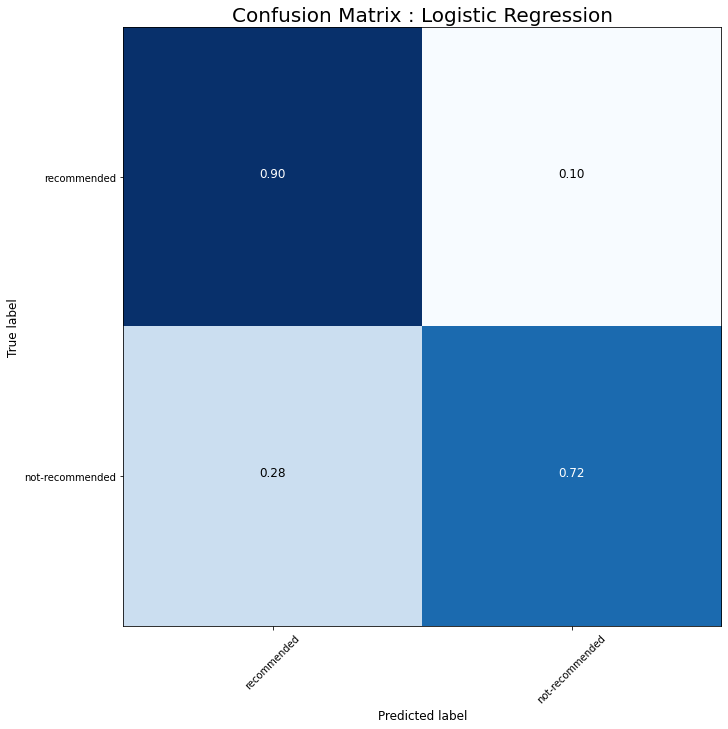

Classification Report : Random Forest

-------------------------------------
                 precision    recall  f1-score   support

    recommended       0.86      0.99      0.92     12994
not-recommended       0.82      0.29      0.43      2854

       accuracy                           0.86     15848
      macro avg       0.84      0.64      0.68     15848
   weighted avg       0.86      0.86      0.83     15848

Confusion Matrix : Random Forest

-------------------------------------


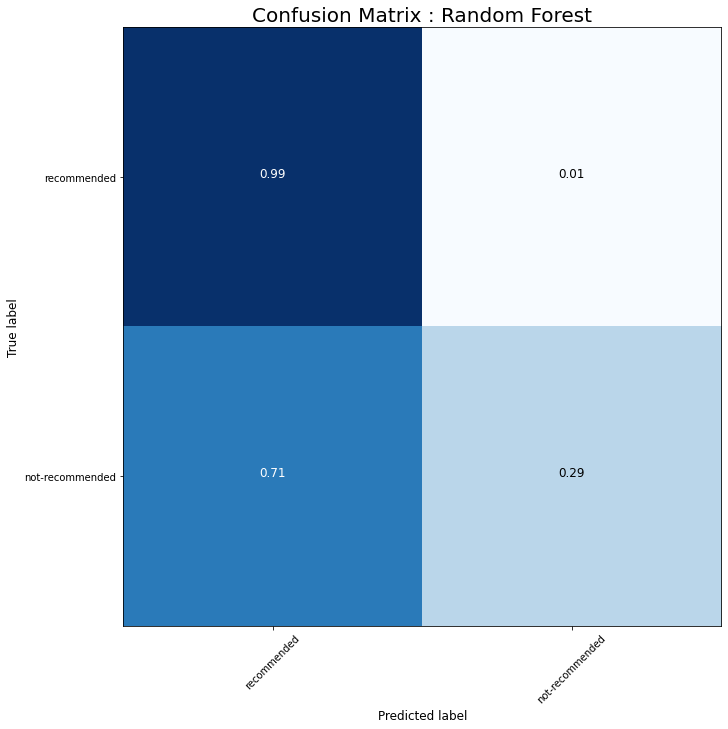

Classification Report : Support Vector Machine

-------------------------------------
                 precision    recall  f1-score   support

    recommended       0.92      0.90      0.91     12994
not-recommended       0.57      0.63      0.60      2854

       accuracy                           0.85     15848
      macro avg       0.74      0.76      0.75     15848
   weighted avg       0.86      0.85      0.85     15848

Confusion Matrix : Support Vector Machine

-------------------------------------


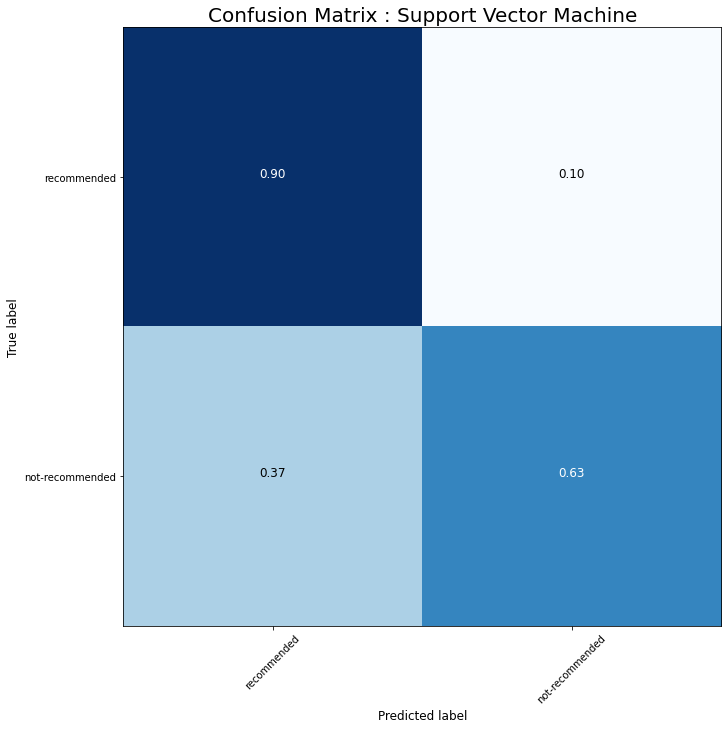

In [29]:
# combine the features
feature_combiner = FeatureUnion([('numeric', numeric_preproc), ('text', n_grams_preproc)])

for model in models.items():
    
    # create the pipeline
    pipe = Pipeline([
        ('preproc', feature_combiner),
        ('clf', model[1])
    ])

    # print classification reports
    y_pred = cross_val_predict(pipe, X_train_bow, y_train)
    print(f'Classification Report : {model[0]}\n')
    print('-------------------------------------')
    print(classification_report(y_train, y_pred, target_names=TARGETS))

    # print confusion matrices
    print(f'Confusion Matrix : {model[0]}\n')
    print('-------------------------------------')
    plot_confusion_matrix(confusion_matrix(y_train, y_pred), classes=['recommended','not-recommended'], normalize=True, title=f'Confusion Matrix : {model[0]}')
    plt.grid(False)
    plt.savefig(f'../assets/eval/ngrams_{model[0].replace(" ", "_").lower()}.png')
    plt.show()

## TF-IDF Models

Classification Report : Logistic Regression

-------------------------------------
                 precision    recall  f1-score   support

    recommended       0.96      0.86      0.91     12994
not-recommended       0.57      0.83      0.67      2854

       accuracy                           0.86     15848
      macro avg       0.76      0.84      0.79     15848
   weighted avg       0.89      0.86      0.87     15848

Confusion Matrix : Logistic Regression

-------------------------------------


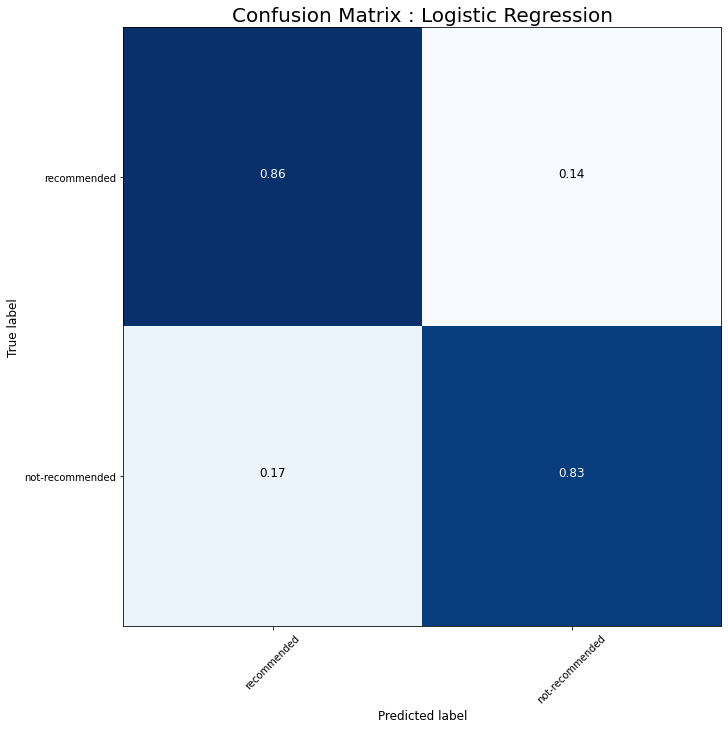

Classification Report : Random Forest

-------------------------------------
                 precision    recall  f1-score   support

    recommended       0.86      0.99      0.92     12994
not-recommended       0.84      0.24      0.38      2854

       accuracy                           0.85     15848
      macro avg       0.85      0.62      0.65     15848
   weighted avg       0.85      0.85      0.82     15848

Confusion Matrix : Random Forest

-------------------------------------


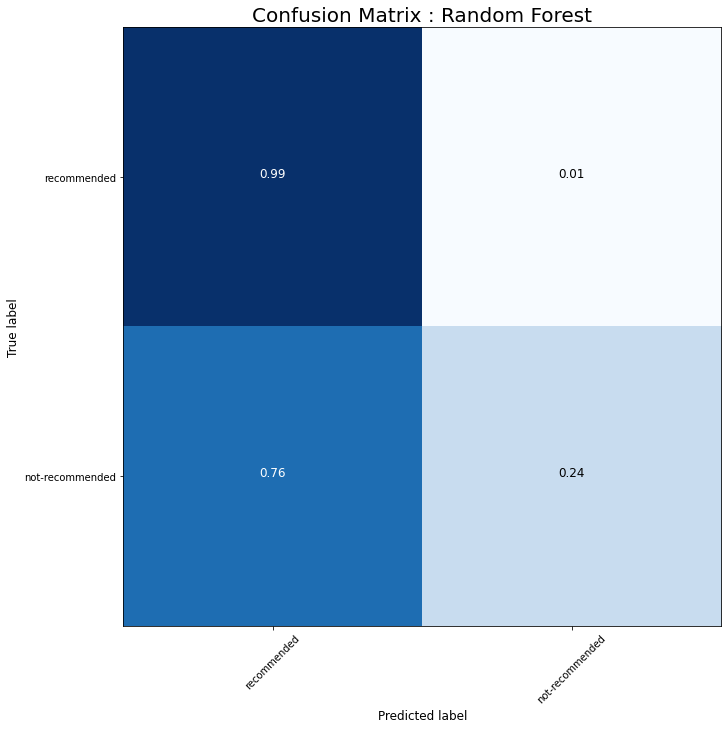

Classification Report : Support Vector Machine

-------------------------------------
                 precision    recall  f1-score   support

    recommended       0.94      0.88      0.91     12994
not-recommended       0.58      0.76      0.66      2854

       accuracy                           0.86     15848
      macro avg       0.76      0.82      0.78     15848
   weighted avg       0.88      0.86      0.86     15848

Confusion Matrix : Support Vector Machine

-------------------------------------


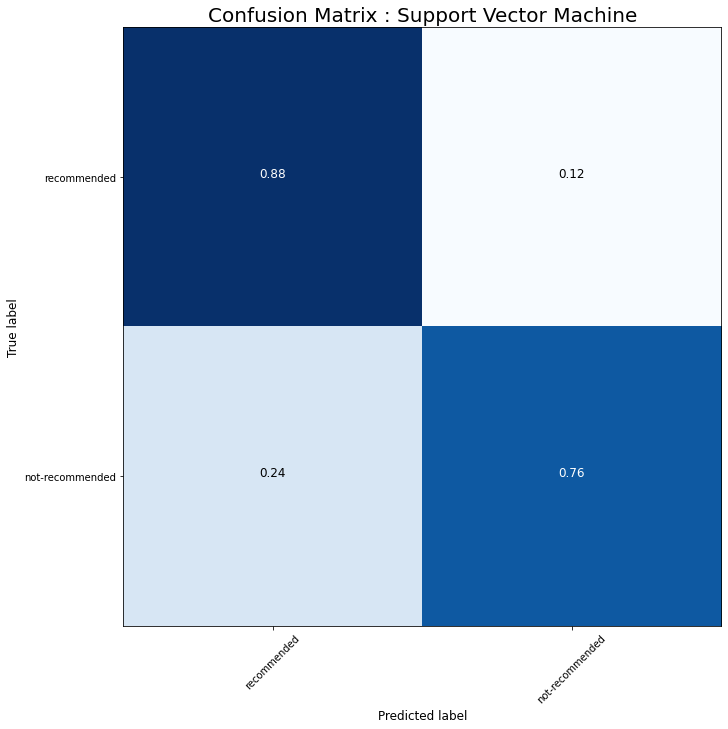

In [30]:
# combine the features
feature_combiner = FeatureUnion([('numeric', numeric_preproc), ('text', tfidf_preproc)])

for model in models.items():
    
    # create the pipeline
    pipe = Pipeline([
        ('preproc', feature_combiner),
        ('clf', model[1])
    ])

    # print classification reports
    y_pred = cross_val_predict(pipe, X_train_bow, y_train)
    print(f'Classification Report : {model[0]}\n')
    print('-------------------------------------')
    print(classification_report(y_train, y_pred, target_names=TARGETS))

    # print confusion matrices
    print(f'Confusion Matrix : {model[0]}\n')
    print('-------------------------------------')
    plot_confusion_matrix(confusion_matrix(y_train, y_pred), classes=['recommended','not-recommended'], normalize=True, title=f'Confusion Matrix : {model[0]}')
    plt.grid(False)
    plt.savefig(f'../assets/eval/tfidf_{model[0].replace(" ", "_").lower()}.png')
    plt.show()

## Word-2-Vec

In [31]:
# define the preprocessor pipelines
MAX_FEAT = 5000 # maximum features from the word vector representation
NUMERICALS = ['subjectivity', 'negative', 'neutral', 'positive', 't_n_tokens', 't_polarity', 't_compound']
TARGETS = ['recommended', 'not-recommended'] # REMEMBER; these need to be in order of highest frequency

numeric_preproc = ColumnTransformer([('scaler', MinMaxScaler(), NUMERICALS)])

# define models
log_reg_base = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
rand_frst_base = RandomForestClassifier(random_state=42)
svm_base = LinearSVC(class_weight='balanced', max_iter=MAX_FEAT)
models = {
    'Logistic Regression': log_reg_base, 
    'Random Forest': rand_frst_base, 
    'Support Vector Machine': svm_base
}

Classification Report : Logistic Regression

-------------------------------------
                 precision    recall  f1-score   support

    recommended       0.91      0.74      0.82     12994
not-recommended       0.37      0.68      0.48      2854

       accuracy                           0.73     15848
      macro avg       0.64      0.71      0.65     15848
   weighted avg       0.82      0.73      0.76     15848

Confusion Matrix : Logistic Regression

-------------------------------------


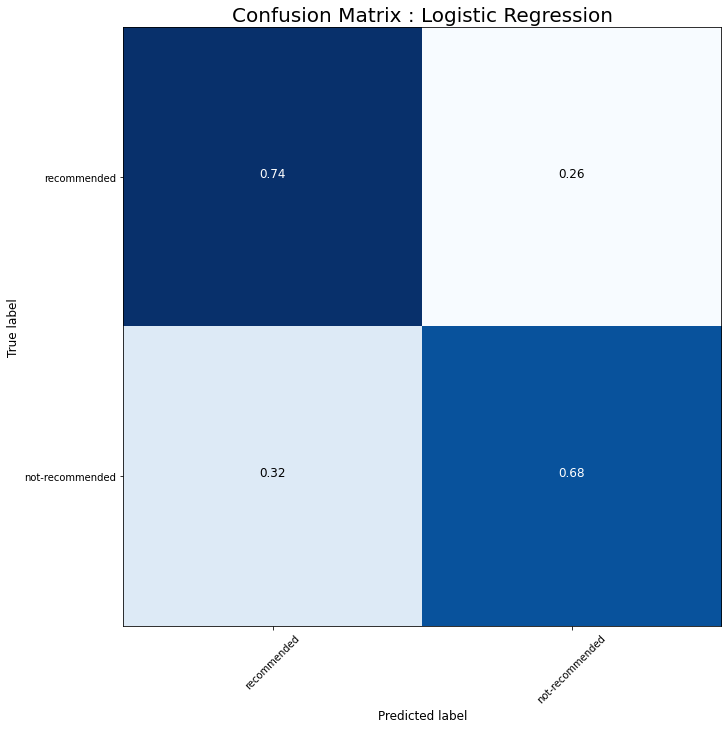

Classification Report : Random Forest

-------------------------------------
                 precision    recall  f1-score   support

    recommended       0.85      0.96      0.90     12994
not-recommended       0.56      0.23      0.33      2854

       accuracy                           0.83     15848
      macro avg       0.70      0.60      0.61     15848
   weighted avg       0.80      0.83      0.80     15848

Confusion Matrix : Random Forest

-------------------------------------


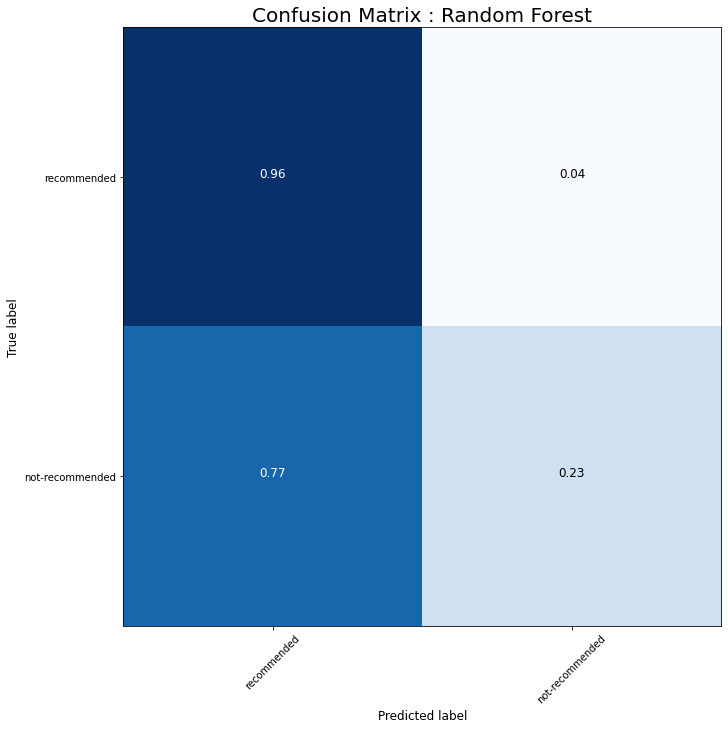

Classification Report : Support Vector Machine

-------------------------------------
                 precision    recall  f1-score   support

    recommended       0.91      0.74      0.82     12994
not-recommended       0.36      0.69      0.48      2854

       accuracy                           0.73     15848
      macro avg       0.64      0.71      0.65     15848
   weighted avg       0.82      0.73      0.75     15848

Confusion Matrix : Support Vector Machine

-------------------------------------


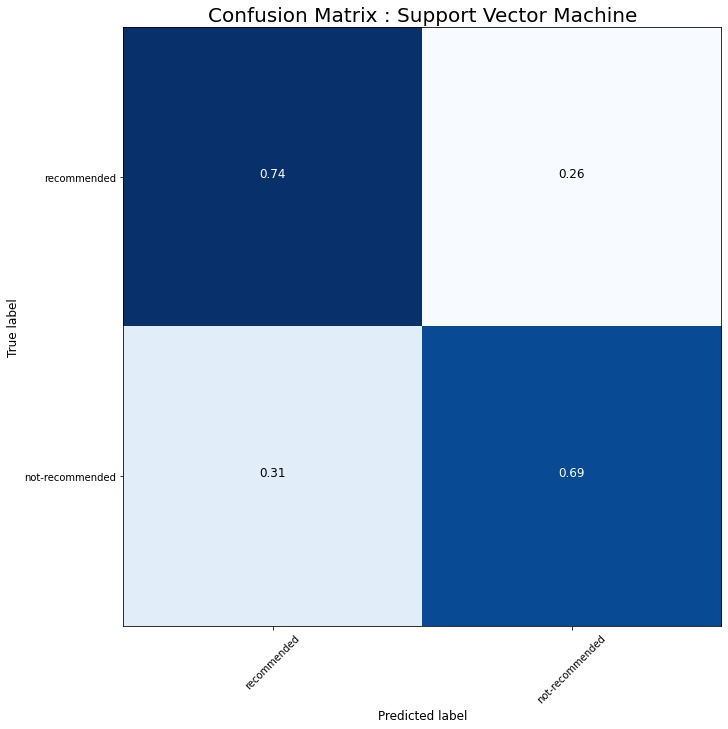

In [32]:
# combine the features
feature_combiner = FeatureUnion([('numeric', numeric_preproc)])

for model in models.items():
    
    # create the pipeline
    pipe = Pipeline([
        ('preproc', feature_combiner),
        ('clf', model[1])
    ])

    # print classification reports
    y_pred = cross_val_predict(pipe, X_train_emb, y_train)
    print(f'Classification Report : {model[0]}\n')
    print('-------------------------------------')
    print(classification_report(y_train, y_pred, target_names=TARGETS))

    # print confusion matrices
    print(f'Confusion Matrix : {model[0]}\n')
    print('-------------------------------------')
    plot_confusion_matrix(confusion_matrix(y_train, y_pred), classes=['recommended','not-recommended'], normalize=True, title=f'Confusion Matrix : {model[0]}')
    plt.grid(False)
    plt.savefig(f'../assets/eval/w2v_{model[0].replace(" ", "_").lower()}.png')
    plt.show()